### Make boundary conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import sys
sys.path.append('/users/birgal/')
from nemo_python.interpolation import interp_latlon_cf

#### Functions

In [2]:
def prepare_bdy_transect(month=1, bdy_lat=-50):
    # Arguments:
    # month --- to look at
    # bdy_lat --- latitude of boundary slice
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude

    # Load datasets:
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))

    # Find strip of points nearest bdy_lat (with edges +/- 1 and fill any zeros with NaNs:
    bdy_ind = np.argmin(np.abs(SOSE_sal.YC.values - bdy_lat))
    SOSE_sal_proc  = xr.where(SOSE_sal.SALT.isel(YC=slice(bdy_ind-1, bdy_ind+2)) ==0, 
                              np.nan, SOSE_sal.isel(YC=slice(bdy_ind-1, bdy_ind+2)))
    SOSE_temp_proc = xr.where(SOSE_temp.THETA.isel(YC=slice(bdy_ind-1, bdy_ind+2)) ==0, 
                              np.nan, SOSE_temp.isel(YC=slice(bdy_ind-1, bdy_ind+2)))

    # And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
    SOSE_sal_proc['XC']  = xr.where(SOSE_sal_proc.XC  > 180, SOSE_sal_proc.XC  - 360, SOSE_sal_proc.XC)
    SOSE_temp_proc['XC'] = xr.where(SOSE_temp_proc.XC > 180, SOSE_temp_proc.XC - 360, SOSE_temp_proc.XC)
    
    SOSE_sal_proc  = SOSE_sal_proc.sortby('XC')
    SOSE_temp_proc = SOSE_temp_proc.sortby('XC')
    
    return SOSE_sal_proc, SOSE_temp_proc

In [144]:
def plot_bdy_transect(month, model_S, model_T, SOSE_S, SOSE_T, 
                      Trange=(1,10), Srange=(33.4, 34.6), ylim=(1500,0)):
                         
    fig, ax = plt.subplots(4,1, figsize=(18,12))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                          
    kwargs_T = {'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('B-SOSE observations')
    ax[1].set_title('Model boundary condition')
    ax[2].set_title('B-SOSE observations')
    ax[3].set_title('Model boundary condition')
    
    model_T_proc = model_T.sortby('x')
    model_S_proc = model_S.sortby('x')
    
    cm1 = ax[0].pcolormesh(SOSE_T.XC, -1*SOSE_T.Z, SOSE_T.THETA, **kwargs_T)
    cm2 = ax[1].pcolormesh(model_T_proc.x, model_T_proc.Z, model_T_proc.THETA, **kwargs_T)
    cm3 = ax[2].pcolormesh(SOSE_S.XC, -1*SOSE_S.Z, SOSE_S.SALT, **kwargs_S)
    cm4 = ax[3].pcolormesh(model_S_proc.x, model_S_proc.Z, model_S_proc.SALT, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Salinity (g/kg)')
    
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(ylim[0],ylim[1])
    ax[3].set_xlabel('Longitude')

    return fig

#### Definitions

In [4]:
# # File locations Jasmin:
# folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
# folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
# folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# coordinates_file='/gws/nopw/j04/terrafirma/kaight/NEMO_AIS/coordinates_AIS.nc'
# meshmask_file   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231017.nc'

#  File locations BAS:
folder_SOSE = '/data/oceans_output/shelf/birgal/B-SOSE/'
folder_BC   = '/data/oceans_output/shelf/birgal/boundary-conditions/'
folder_NEMO = '/data/oceans_output/shelf/birgal/bathymetry/'

coordinates_file='/data/oceans_output/shelf/birgal/bathymetry/coordinates_AIS.nc'
meshmask_file   ='/data/oceans_output/shelf/birgal/bathymetry/mesh_mask-20231017.nc'

#### Make boundary condition

In [5]:
# Load files:
nemo = xr.open_dataset(coordinates_file).squeeze()
mesh = xr.open_dataset(meshmask_file)

nemo_depths = mesh.nav_lev.values

In [6]:
month = 1

# Index of boundary location (Python-based numbering); assumes you want all longitudes
bdy_ind = 452
bdy_lat = nemo.nav_lat.isel(y=452).mean().values
bdy_lon = nemo.nav_lon.isel(y=452)

# Load SOSE observational data with a one cell buffer on either side of the boundary latitude
SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=bdy_lat)
SOSE_S_mod     = SOSE_S.rename({'XC':'lon', 'YC':'lat'})
SOSE_T_mod     = SOSE_T.rename({'XC':'lon', 'YC':'lat'})
SOSE_depths    = SOSE_S_mod.Z.values

Horizontal interpolation

In [8]:
for depth in SOSE_depths[0:2]:
    source = xr.Dataset({'lon':SOSE_S_mod.lon, 'lat':SOSE_S_mod.lat, 
                         'SALT':SOSE_S_mod.SALT.sel(Z=depth), 'THETA':SOSE_T_mod.THETA.sel(Z=depth)})

In [52]:
# Interpolate observations from source to nemo grid along the longitude and latitude grid:
datasets = []
for depth in SOSE_depths:
    source = xr.Dataset({'lon':SOSE_S_mod.lon, 'lat':SOSE_S_mod.lat, 
                         'SALT':SOSE_S_mod.SALT.sel(Z=depth), 'THETA':SOSE_T_mod.THETA.sel(Z=depth)})

    # Interpolate slices of depth levels along lat-lon: specify -1 and +1 NEMO grid cell on either side 
    data_interp = interp_latlon_cf(source, nemo.isel(y=slice(bdy_ind-1, bdy_ind+2)), 
                                   pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

    # Add interpolated layers to dataset, selecting only the slice of values at the specified boundary
    datasets.append(data_interp.isel(y=[1]))
    
SOSE_horizon_interp = xr.concat(datasets, dim='src_depth').assign_coords(src_depth=-1*SOSE_depths, 
                                                                         x=nemo.nav_lon.isel(y=bdy_ind), 
                                                                         y=nemo.nav_lat.isel(y=bdy_ind))

Vertical interpolation

In [191]:
# Compute edges of the z-levels
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':
        z_centres = mesh.gdept_0.isel(time_counter=0, y=0, x=0).values
        dz        = mesh.e3t_0.isel(time_counter=0, y=0, x=0).values
    elif mtype=='SOSE':
        z_centres = -1*mesh.Z.values 
        dz        = mesh.drF.values
    
    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

Alright... I think the method below calculates things correctly in a conservative manner. Now, just need to rewrite it in a more generalized and vectorized way. Still check:
- how the method behaves near the sea floor and at the surface (when taking the proportional size, only do so if there are multiple)
- whether the method does okay with the near-bottom partial steps

In [388]:
Salt = np.zeros((121)); Temp = np.zeros((121));
for n in range(0,121):

    printt = True if (n < 25) and (n>23) else False
    
    NEMO_top_edge = nemo_edges[0][n]
    NEMO_bot_edge = nemo_edges[2][n]
    if printt: print(f'NEMO: {NEMO_top_edge:.2f}-{NEMO_bot_edge:.2f} m');

    # find the source edges that fall within the depth ranges of the NEMO grid cells:
    for zs, zs_centres in enumerate(sose_edges[1]):
        src_top_edge = sose_edges[0][zs]
        src_bot_edge = sose_edges[2][zs]

        if (NEMO_top_edge >= src_top_edge) and (NEMO_bot_edge < src_bot_edge):
            Salt[n] = (source.SALT.isel(src_depth=zs, y=0, x=0))*(NEMO_bot_edge - NEMO_top_edge)
            Temp[n] = (source.THETA.isel(src_depth=zs, y=0, x=0))*(NEMO_bot_edge - NEMO_top_edge)
            if printt: print('opt1, ', zs, 'sose: ', src_top_edge, src_bot_edge, 'salt: ', source.SALT.isel(src_depth=zs, y=0, x=0).values);

        elif ((NEMO_top_edge >= src_top_edge) and (src_bot_edge < NEMO_bot_edge) and (src_bot_edge > NEMO_top_edge)):
            Salt[n] = Salt[n] + (src_bot_edge - NEMO_top_edge)*source.SALT.isel(src_depth=zs, y=0, x=0)
            Temp[n] = Temp[n] + (src_bot_edge - NEMO_top_edge)*source.THETA.isel(src_depth=zs, y=0, x=0)
            if printt: print('opt2, ', zs, 'sose: ', src_top_edge, src_bot_edge, 'salt: ', source.SALT.isel(src_depth=zs, y=0, x=0).values);
            if printt: print('    , ', (src_bot_edge - NEMO_top_edge))

        elif ((NEMO_top_edge < src_top_edge) and (src_bot_edge > NEMO_bot_edge) and (src_top_edge < NEMO_bot_edge)):
            Salt[n] = Salt[n] + (NEMO_bot_edge - src_top_edge)*source.SALT.isel(src_depth=zs, y=0, x=0)
            Temp[n] = Temp[n] + (NEMO_bot_edge - src_top_edge)*source.THETA.isel(src_depth=zs, y=0, x=0)
            if printt: print('opt3, ', zs, 'sose: ', src_top_edge, src_bot_edge, 'salt: ', source.SALT.isel(src_depth=zs, y=0, x=0).values);
            if printt: print('    , ', (NEMO_bot_edge - src_top_edge))

        elif ((NEMO_top_edge < src_top_edge) and (src_bot_edge < NEMO_bot_edge) and (src_top_edge < NEMO_bot_edge)):
            Salt[n] = Salt[n] + (src_bot_edge - src_top_edge)*source.SALT.isel(src_depth=zs, y=0, x=0)
            Temp[n] = Temp[n] + (src_bot_edge - src_top_edge)*source.THETA.isel(src_depth=zs, y=0, x=0)
            if printt: print('opt4, ', zs, 'sose: ', src_top_edge, src_bot_edge, 'salt: ', source.SALT.isel(src_depth=zs, y=0, x=0).values);
            if printt: print('    , ', (src_bot_edge - src_top_edge))

                
    if printt: print('Salt: ', Salt[n])
    if printt: print('--', NEMO_bot_edge - NEMO_top_edge, '--')
    Salt[n] = Salt[n]/(NEMO_bot_edge - NEMO_top_edge)
    Temp[n] = Temp[n]/(NEMO_bot_edge - NEMO_top_edge)

NEMO: 99.34-110.25 m
opt2,  11 sose:  90.0 100.0 salt:  33.60719471197723
    ,  0.6606556044175704
opt4,  12 sose:  100.0 110.0 salt:  33.610151049318006
    ,  10.0
opt3,  13 sose:  110.0 120.0 salt:  33.612798163092606
    ,  0.25167825608195926
Salt:  366.7639024521224
-- 10.91233386049953 --


In [415]:
print('Salt flux over full water column')
print(np.nansum(SOSE_horizon_interp.SALT.isel(y=0, x=0).values * SOSE_S_mod.drF.values))
print(np.nansum(Salt * mesh.e3t_0.isel(time_counter=0, y=0, x=0).values))

Salt flux over full water column
19619.954554754237
19434.73626838333


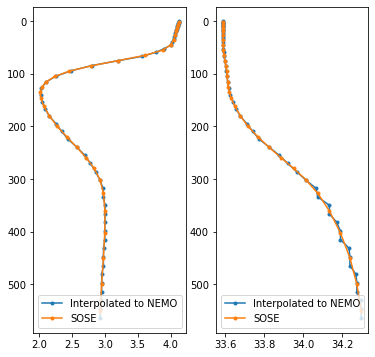

In [390]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
    
ax[0].plot(Temp, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[0].plot(SOSE_horizon_interp.THETA.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')

ax[1].plot(Salt, SOSE_vert_interp.Z, '.-', label='Interpolated to NEMO')
ax[1].plot(SOSE_horizon_interp.SALT.isel(y=0, x=0), -1*SOSE_depths, '.-', label='SOSE')
# ax[1].set_xlim(33, 34)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.legend()
#     axis.set_ylim(500,300)

In [391]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    # Input: source --- xr dataset with variables .SALT, .THETA and dims y, src_depth
    
    NEMO_top_edge = nemo_edges[0][n]
    NEMO_bot_edge = nemo_edges[2][n]

    Salt = 0; Temp=0;
    # find the source edges that fall within the depth ranges of the NEMO grid cells:
    for zs, zs_centres in enumerate(source_edges[1]):
        src_top_edge = source_edges[0][zs]
        src_bot_edge = source_edges[2][zs]

        if (NEMO_top_edge >= src_top_edge) and (NEMO_bot_edge < src_bot_edge):
            Salt = (source.SALT.isel(src_depth=zs))*(NEMO_bot_edge - NEMO_top_edge)
            Temp = (source.THETA.isel(src_depth=zs))*(NEMO_bot_edge - NEMO_top_edge)

        elif ((NEMO_top_edge >= src_top_edge) and (src_bot_edge < NEMO_bot_edge) and (src_bot_edge > NEMO_top_edge)):
            Salt = Salt + (src_bot_edge - NEMO_top_edge)*source.SALT.isel(src_depth=zs)
            Temp = Temp + (src_bot_edge - NEMO_top_edge)*source.THETA.isel(src_depth=zs)

        elif ((NEMO_top_edge < src_top_edge) and (src_bot_edge > NEMO_bot_edge) and (src_top_edge < NEMO_bot_edge)):
            Salt = Salt + (NEMO_bot_edge - src_top_edge)*source.SALT.isel(src_depth=zs)
            Temp = Temp + (NEMO_bot_edge - src_top_edge)*source.THETA.isel(src_depth=zs)
            
        elif ((NEMO_top_edge < src_top_edge) and (src_bot_edge < NEMO_bot_edge) and (src_top_edge < NEMO_bot_edge)):
            Salt = Salt + (src_bot_edge - src_top_edge)*source.SALT.isel(src_depth=zs)
            Temp = Temp + (src_bot_edge - src_top_edge)*source.THETA.isel(src_depth=zs)

    Salt = Salt/(NEMO_bot_edge - NEMO_top_edge)
    Temp = Temp/(NEMO_bot_edge - NEMO_top_edge)
        
    dataset = xr.Dataset({'x':source.lon, 'y':source.lat, 'Z':nemo_edges[1][n], 
                          'SALT':(('y', 'x'), Salt.values), 'THETA':(('y', 'x'), Temp.values)})
        
    return dataset

In [392]:
nemo_edges = vertical_edges(mesh, mtype='nemo')
sose_edges = vertical_edges(SOSE_S_mod, mtype='SOSE')

model_BCs = []
for n, ndepth in enumerate(nemo_depths):
   
    source = xr.Dataset({'lon':nemo.nav_lon.isel(y=bdy_ind), 'lat':nemo.nav_lat.isel(y=bdy_ind), 
                         'SALT':SOSE_horizon_interp.SALT, 'THETA':SOSE_horizon_interp.THETA})

    # Interpolate slices from SOSE to NEMO depth levels
    data_interp = interp_depth(source, sose_edges, nemo_edges, n)
    
    # Add interpolated layers to dataset
    model_BCs.append(data_interp)
    
SOSE_vert_interp = xr.concat(model_BCs, dim='Z').assign(Z=nemo_depths)

In [412]:
print('Salt flux')
print(np.nansum(SOSE_horizon_interp.isel(y=0, x=0).SALT.values * -1*SOSE_depths))
print(np.nansum(SOSE_vert_interp.isel(y=0,x=0).SALT.values*nemo_depths)/nemo_depths[54])

print('Salt flux')
print(SOSE_horizon_interp.isel(y=0, x=0).SALT.sum(dim='src_depth').values)
print(SOSE_vert_interp.isel(y=0,x=0).SALT.sum(dim='Z').values)

Salt flux
189599.8601687642
648.7340578064646
Salt flux
1046.9261897940294
1859.87532489234


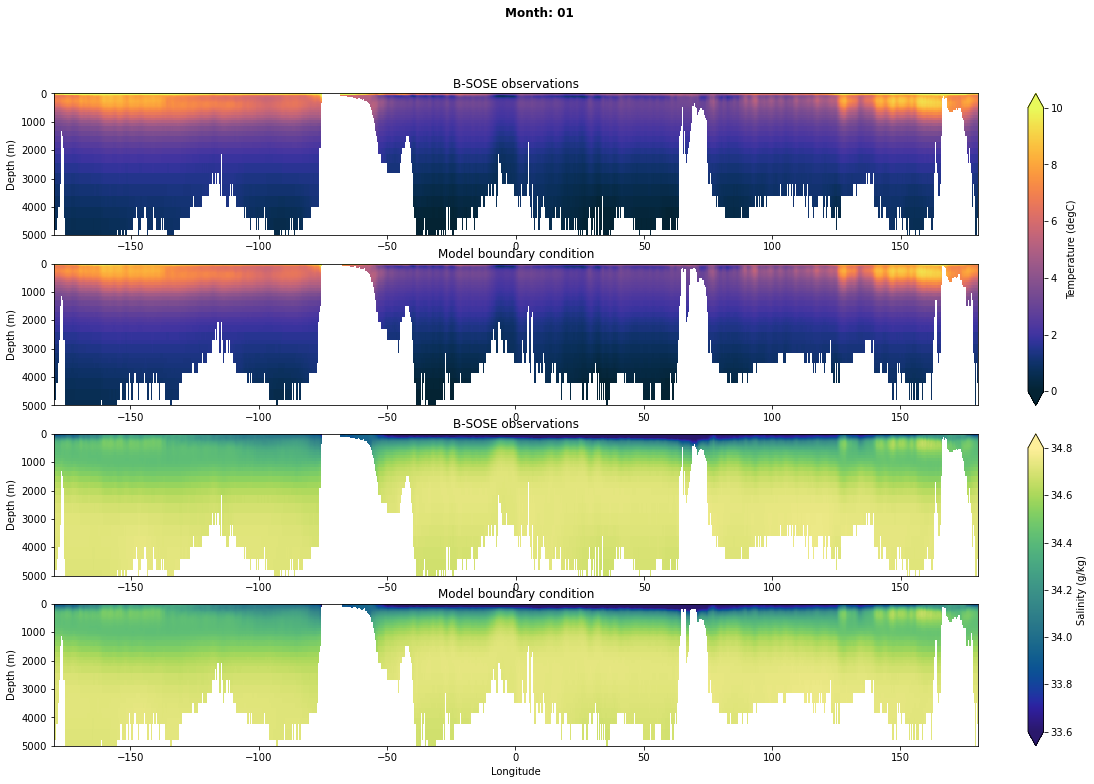

In [373]:
fig1 = {}
fig1[f'm{month:02}'] = plot_bdy_transect(month, SOSE_vert_interp.isel(y=0), SOSE_vert_interp.isel(y=0), SOSE_S.isel(YC=0), SOSE_T.isel(YC=0), 
                                         Trange=(0,10), Srange=(33.6, 34.8), ylim=(5000,0))

# pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}WOA_SOSE_boundary_transect_1500m.pdf")
# for month in range(1,13):
#     pdf1.savefig(fig1[f'm{month:02}'])
# pdf1.close()